In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules, fpmax
from mlxtend.preprocessing import TransactionEncoder
from PD_freqitems import freqitemsets
from pyfim import pyeclat

In [3]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
prod_dict={}
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname
    prod_dict[pid] = pname

del products[0] #the products list contains a 0 as the first element
#products

In [6]:
#read transactions
orders=pickle.load(open("order_products.pickle", "rb"))

In [7]:
#check products on order 2:
#for prod in orders[2]: print(products[prod])

In [8]:
# Convert the transaction data into a list of lists
orders_list = [list(order) for order in orders.values()]
#orders_list

In [9]:
# Encode the transaction data as a binary matrix
te = TransactionEncoder()
te_ary = te.fit_transform(orders_list, sparse=True)

df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
#df

In [10]:
df.columns = [prod_dict[str(key)] for key in df.columns]
#df

In [13]:
D={"threshold": [0.2, 0.1, 0.05, 0.02, 0.01], 
   "num_itemsets":[],
   "apriori":[], 
   "FP-growth":[], 
   "ECLAT":[], 
   "PD":[]}

for min_supp in D["threshold"]:
    t0 = time.time()
    FI_apriori=apriori(df, min_supp)
    t1 = time.time()
    D["num_itemsets"].append(FI_apriori.shape[0])
    D["apriori"].append(t1-t0)

    FI_fpg= fpgrowth(df, min_supp)
    t2 = time.time()
    D["FP-growth"].append(t2-t1)

    FI_eclat= pyeclat(orders_list, min_supp)    
    t3 = time.time()
    D["ECLAT"].append(t3-t2)

    FI_pdfis= freqitemsets(orders_list, min_supp)    
    t4 = time.time()
    D["PD"].append(t4-t3)

    
    print(min_supp, FI_apriori.shape[0],"\n\tApriori time:", t1-t0, 
          "\n\tFP-growth time:",t2-t1,
          "\n\tECLAT time:", t3-t2,
          "\n\tPD time:", t4-t3)
    

df_performance=pd.DataFrame(D)
df_performance

0.2 0 
	Apriori time: 6.3965675830841064 
	FP-growth time: 15.70045804977417 
	ECLAT time: 128.55163478851318 
	PD time: 59.036895990371704
0.1 2 
	Apriori time: 5.572005033493042 
	FP-growth time: 17.515021324157715 
	ECLAT time: 91.92771744728088 
	PD time: 59.23741841316223
0.05 6 
	Apriori time: 6.754559755325317 
	FP-growth time: 18.09499740600586 
	ECLAT time: 147.3803403377533 
	PD time: 39.31001329421997
0.02 39 
	Apriori time: 36.78520894050598 
	FP-growth time: 21.018460512161255 
	ECLAT time: 108.9571442604065 
	PD time: 39.92421579360962


C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\dgonc\anaconda3\lib\site-packages\scipy\sparse\compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other


0.01 102 
	Apriori time: 248.26823377609253 
	FP-growth time: 50.2638578414917 
	ECLAT time: 96.81559300422668 
	PD time: 68.22693014144897


,threshold,num_itemsets,apriori,FP-growth,ECLAT,PD
0,0.20,0,6.396568,15.700458,128.551635,59.036896
1,0.10,2,5.572005,17.515021,91.927717,59.237418
2,0.05,6,6.754560,18.094997,147.380340,39.310013
3,0.02,39,36.785209,21.018461,108.957144,39.924216
4,0.01,102,248.268234,50.263858,96.815593,68.226930


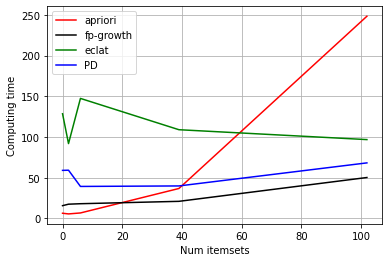

In [14]:
plt.plot(df_performance["num_itemsets"], df_performance["apriori"], c='r', label='apriori')
plt.plot(df_performance["num_itemsets"], df_performance["FP-growth"], c='k', label='fp-growth')
plt.plot(df_performance["num_itemsets"], df_performance["ECLAT"], c='g', label='eclat')
plt.plot(df_performance["num_itemsets"], df_performance["PD"], c='b', label='PD')
plt.xlabel("Num itemsets")
plt.ylabel("Computing time")
plt.grid()
plt.legend()
plt.show()

Although the apriori algorithm has the best performance for higher support thresholds, it is quickly outperformed by all the other algorithms for lower support thresholds. FP-growth and PD appear to behave relatively similar performance-wise, with the former having an advantage over PD. 

ECLAT did not have a good performance, which is surprising, since this algorithm supposedly scales well for large datasets.

In [16]:
FI_fpgrowth = fpgrowth(df, min_support=0.02, use_colnames=True)
FI_fpgrowth['length'] = FI_fpgrowth['itemsets'].apply(lambda x: len(x))
FI_fpgrowth.sort_values(by=['length'], ascending=False)

,support,itemsets,length
0,0.022625,(Carrots),1
29,0.034147,(Organic Garlic),1
22,0.027880,(Organic Fuji Apple),1
23,0.044466,(Strawberries),1
24,0.031124,(Organic Blueberries),1
25,0.027294,(Organic Lemon),1
26,0.026208,(Organic Grape Tomatoes),1
27,0.022659,(Organic Gala Apples),1
28,0.025006,(Organic Cucumber),1
30,0.023380,(Organic Large Extra Fancy Fuji Apple),1


In [17]:
FI_fpgrowth = fpgrowth(df, min_support=0.01, use_colnames=True)
FI_fpgrowth['length'] = FI_fpgrowth['itemsets'].apply(lambda x: len(x))
FI_fpgrowth.sort_values(by=['length'], ascending=False)

,support,itemsets,length
115,0.012825,"(Strawberries, Banana)",2
108,0.012599,"(Bag of Organic Bananas, Organic Raspberries)",2
102,0.015987,"(Banana, Organic Baby Spinach)",2
103,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2
105,0.019391,"(Bag of Organic Bananas, Organic Hass Avocado)",2
...,...,...,...
34,0.015215,(Organic D'Anjou Pears),1
33,0.047485,(Large Lemon),1
32,0.010063,(Feta Cheese Crumbles),1
31,0.017259,(Green Bell Pepper),1


There are no 2-itemsets for FP-growth when support = 0.02, in contrast to when support = 0.01. Therefore, we will continue our analysis with support = 0.01, otherwise we would not be able to generate association rules.

In [19]:
FI_fpgrowth[FI_fpgrowth['length'] == 2]

,support,itemsets,length
102,0.015987,"(Banana, Organic Baby Spinach)",2
103,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2
104,0.015668,"(Organic Baby Spinach, Bag of Organic Bananas)",2
105,0.019391,"(Bag of Organic Bananas, Organic Hass Avocado)",2
106,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
107,0.012689,"(Organic Strawberries, Organic Hass Avocado)",2
108,0.012599,"(Bag of Organic Bananas, Organic Raspberries)",2
109,0.010533,"(Organic Strawberries, Organic Raspberries)",2
110,0.017468,"(Banana, Organic Strawberries)",2
111,0.019170,"(Bag of Organic Bananas, Organic Strawberries)",2


Of the total 116 itemsets generated by FP-growth, 14 are 2-itemsets. At a first glance, they seem to make sense - different kinds of fruits are frequently bought together in real life, as well as fruits and vegetables.

Now let's check all the rules and choose a set that seems relevant:

In [49]:
all_rules = association_rules(FI_fpgrowth, metric="support", min_threshold=0.01)
all_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Banana),(Organic Baby Spinach),0.146993,0.075251,0.015987,0.108758,1.445272,0.004925,1.037596,0.361180
1,(Organic Baby Spinach),(Banana),0.075251,0.146993,0.015987,0.212445,1.445272,0.004925,1.083108,0.333159
2,(Organic Baby Spinach),(Organic Strawberries),0.075251,0.082331,0.011862,0.157630,1.914594,0.005666,1.089390,0.516568
3,(Organic Strawberries),(Organic Baby Spinach),0.082331,0.075251,0.011862,0.144074,1.914594,0.005666,1.080408,0.520554
4,(Organic Baby Spinach),(Bag of Organic Bananas),0.075251,0.118030,0.015668,0.208217,1.764107,0.006787,1.113904,0.468388
5,(Bag of Organic Bananas),(Organic Baby Spinach),0.118030,0.075251,0.015668,0.132750,1.764107,0.006787,1.066301,0.491106
6,(Bag of Organic Bananas),(Organic Hass Avocado),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
7,(Organic Hass Avocado),(Bag of Organic Bananas),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011
8,(Organic Baby Spinach),(Organic Hass Avocado),0.075251,0.066436,0.010856,0.144266,2.171499,0.005857,1.090951,0.583389
9,(Organic Hass Avocado),(Organic Baby Spinach),0.066436,0.075251,0.010856,0.163406,2.171499,0.005857,1.105375,0.577881


The conviction values do not seem to change much from rule to rule, the majority having a value less than 1.2 and all having a value greater than 1, which indicates that the presence of the antecedent has a positive effect on the occurence of the consequent for all rules. As such, we will not focus too much on this metric. Likewise, the support values are all between 0.01 and 0.02, which means that this metric will not be as appropriate to compare rules as lift and confidence, as we know that for every rule the antecedent and the consequent appear together in 1% of all transactions.

There seems to be a greater range of values for the lift metric, with some rules having a lift value that is twice the value of others. Let's check the ones with lift > 2.5.

In [50]:
all_rules = association_rules(FI_fpgrowth, metric="lift", min_threshold=2.5)
all_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Bag of Organic Bananas),(Organic Raspberries),0.118030,0.042632,0.012599,0.106741,2.503775,0.007567,1.071770,0.680979
1,(Organic Raspberries),(Bag of Organic Bananas),0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944,0.627348
2,(Organic Strawberries),(Organic Raspberries),0.082331,0.042632,0.010533,0.127938,3.000973,0.007023,1.097821,0.726596
3,(Organic Raspberries),(Organic Strawberries),0.042632,0.082331,0.010533,0.247072,3.000973,0.007023,1.218801,0.696467
4,(Organic Fuji Apple),(Banana),0.027880,0.146993,0.010558,0.378693,2.576259,0.006460,1.372923,0.629388
5,(Banana),(Organic Fuji Apple),0.146993,0.027880,0.010558,0.071827,2.576259,0.006460,1.047348,0.717275


Of these rules with a large lift value, three seem the most relevant: 

(Organic Raspberries) => (Bag of Organic Bananas) (confidence = 0.30, lift = 2.50; row 1)

(Organic Raspberries) => (Organic Strawberries) (confidence = 0.35, lift = 3.00; row 3)

(Organic Fuji Apple) => (Banana) (confidence = 0.38, lift = 2.58; row 4)

For example, for this last rule, we can say that 38% of the transactions that contain Organic Fuji Apple also contain Banana, and the probability of Banana being purchased when Organic Fuji Apple is purchased is 2.58 times higher than the probability of Banana being purchased in general. There is a non-random relationship between these two products.

The same logic can be applied to the other rules.

Now, let's identify the maximal itemsets for 2-itemsets with support = 0.01:

In [58]:
FI_fpmax = fpmax(df, min_support=0.01, use_colnames=True)
FI_fpmax['length'] = FI_fpmax['itemsets'].apply(lambda x: len(x))
FI_fpmax.sort_values(by=['length'], ascending=False)
FI_fpmax[FI_fpmax['length'] >= 2]

,support,itemsets,length
85,0.010558,"(Organic Fuji Apple, Banana)",2
91,0.010533,"(Organic Strawberries, Organic Raspberries)",2
92,0.012599,"(Bag of Organic Bananas, Organic Raspberries)",2
95,0.012825,"(Strawberries, Banana)",2
96,0.012716,"(Banana, Large Lemon)",2
97,0.016609,"(Organic Avocado, Banana)",2
98,0.010856,"(Organic Baby Spinach, Organic Hass Avocado)",2
99,0.012689,"(Organic Strawberries, Organic Hass Avocado)",2
100,0.019391,"(Bag of Organic Bananas, Organic Hass Avocado)",2
101,0.011862,"(Organic Baby Spinach, Organic Strawberries)",2


Closed 2-itemsets with support = 0.01: